## importing necessary libs

i'm using poetry for managing dependencies and my virtual env, so i'd recommend to look `pyproject.toml` to know what's been used here.

In [1]:
# import findspark
# from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

## setting up spark session and dataframe

In [ ]:
#https://spark.apache.org/docs/latest/sql-getting-started.html
spark = SparkSession \
        .builder \
        .appName("firstSpark") \
        .getOrCreate()

In [3]:
# loading dataframe
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='true').load(filename)
    return df

#creating a dataframe
df_matches = load_dataframe('./data/matches.csv')
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



In [4]:
# im doing this just to understand zip command

slice_a = 'abcdefg'
slice_b = range(3)
slice_c = 'vwxyz'

print(f'lets go! \nslices:\n\t{slice_a}\n\t{list(slice_b)}\n\t{slice_c}')

# so if i use zip i expect a list with the array values intercalated, until the shorter list reachs its end
print(f'ZIP doing magic!\n\t{list(zip(slice_a, slice_b, slice_c))}') # got what was expected, yay!

# now im using starred expressions used for unpacking lists
unpacked = [*zip(slice_a, slice_b, slice_c)]
print(f'STARRED ZIP doing magic!\n\t{unpacked}') # need to practice more of this, seems useful

lets go! 
slices:
	abcdefg
	[0, 1, 2]
	vwxyz
ZIP doing magic!
	[('a', 0, 'v'), ('b', 1, 'w'), ('c', 2, 'x')]
STARRED ZIP doing magic!
	[('a', 0, 'v'), ('b', 1, 'w'), ('c', 2, 'x')]


In [5]:
# lets rename some of the columns (FTHG, FTAG, FTR)
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]
old_new_cols = [*zip(old_cols, new_cols)]
for old_col, new_col in old_new_cols:
    df_matches = df_matches.withColumnRenamed(old_col, new_col)

df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


## shine pyspark!

### 1) Who are the winners of the D1 division in the Germany Football Association (Bundesliga) between 2000–2010?

In [6]:
df_matches = df_matches \
    .withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)) \
    .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
    .withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))


#bundesliga is a D1 division and we are interested in season <= 2010 and >= 2000
bundesliga = df_matches \
                    .filter((col('Season') >= 2000) & 
                            (col('Season') <= 2010) & 
                            (col('Div') == 'D1'))

# home team features
home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

#away game features 
away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

#### seeing both results

In [7]:
home.toPandas()

,Season,Team,TotalHomeWin,TotalHomeLoss,TotalHomeTie,HomeScoredGoals,HomeAgainstGoals
0,2005,Kaiserslautern,5,7,5,26.0,33.0
1,2006,Cottbus,6,6,5,21.0,22.0
2,2001,St Pauli,4,9,4,19.0,28.0
3,2005,Mainz,6,4,7,31.0,23.0
4,2006,Hamburg,4,4,9,22.0,19.0
...,...,...,...,...,...,...,...
193,2003,Kaiserslautern,8,4,5,25.0,19.0
194,2004,Bielefeld,7,7,3,21.0,21.0
195,2004,Werder Bremen,9,4,4,33.0,15.0
196,2004,Stuttgart,12,3,2,34.0,15.0


In [8]:
away.toPandas()

,Season,Team,TotalAwayWin,TotalAwayLoss,TotalAwayTie,AwayScoredGoals,AwayAgainstGoals
0,2005,Kaiserslautern,3,10,4,21.0,38.0
1,2006,Cottbus,5,9,3,17.0,27.0
2,2001,St Pauli,0,11,6,18.0,42.0
3,2005,Mainz,3,10,4,15.0,24.0
4,2006,Hamburg,6,5,6,21.0,18.0
...,...,...,...,...,...,...,...
193,2003,Kaiserslautern,3,13,1,14.0,43.0
194,2004,Bielefeld,4,9,4,16.0,28.0
195,2004,Werder Bremen,9,7,1,35.0,22.0
196,2004,Stuttgart,5,7,5,20.0,25.0


#### answering the question

In [9]:
# it seems window turns easy to use some aggregation functions like rank and statistical analysis methods
# https://sparkbyexamples.com/pyspark/pyspark-window-functions/
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window)) 

table_df = table.filter(col('TeamPosition') == 1).orderBy(desc('Season')).toPandas()
table_df

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Dortmund,2010,67.0,22.0,45.0,23,5,6,67.65,1
1,Bayern Munich,2009,72.0,31.0,41.0,20,4,10,58.82,1
2,Wolfsburg,2008,80.0,41.0,39.0,21,7,6,61.76,1
3,Bayern Munich,2007,68.0,21.0,47.0,22,2,10,64.71,1
4,Stuttgart,2006,61.0,37.0,24.0,21,6,7,61.76,1
5,Bayern Munich,2005,67.0,32.0,35.0,22,3,9,64.71,1
6,Bayern Munich,2004,75.0,33.0,42.0,24,5,5,70.59,1
7,Werder Bremen,2003,79.0,38.0,41.0,22,4,8,64.71,1
8,Bayern Munich,2002,70.0,25.0,45.0,23,5,6,67.65,1
9,Leverkusen,2001,77.0,38.0,39.0,21,7,6,61.76,1


### 2) Which teams have been relegated in the past 10 years?

In [10]:
bundesliga_last_decade = df_matches \
                        .filter((col('Season') >= 2007) & 
                                (col('Season') <= 2017) & 
                                (col('Div') == 'D1'))

home = bundesliga_last_decade.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

away = bundesliga_last_decade.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals')) \
       .withColumnRenamed('AwayTeam', 'Team')

#### seeing both results

In [11]:
home.sort('Season').toPandas()

,Season,Team,TotalHomeWin,TotalHomeLoss,TotalHomeTie,HomeScoredGoals,HomeAgainstGoals
0,2007,Hansa Rostock,5,8,4,17.0,21.0
1,2007,Cottbus,8,7,2,25.0,20.0
2,2007,Bochum,5,3,9,32.0,28.0
3,2007,Ein Frankfurt,8,5,4,24.0,24.0
4,2007,Stuttgart,12,3,2,39.0,19.0
...,...,...,...,...,...,...,...
193,2017,FC Koln,17,0,0,-17.0,-17.0
194,2017,Wolfsburg,17,0,0,-17.0,-17.0
195,2017,Dortmund,17,0,0,-17.0,-17.0
196,2017,Freiburg,17,0,0,-17.0,-17.0


In [12]:
away.sort('Season').toPandas()

,Season,Team,TotalAwayWin,TotalAwayLoss,TotalAwayTie,AwayScoredGoals,AwayAgainstGoals
0,2007,Hansa Rostock,3,12,2,13.0,31.0
1,2007,Cottbus,1,9,7,10.0,36.0
2,2007,Bochum,5,10,2,16.0,26.0
3,2007,Ein Frankfurt,4,7,6,19.0,26.0
4,2007,Stuttgart,4,11,2,18.0,38.0
...,...,...,...,...,...,...,...
193,2017,FC Koln,0,17,0,-17.0,-17.0
194,2017,Wolfsburg,0,17,0,-17.0,-17.0
195,2017,Dortmund,0,17,0,-17.0,-17.0
196,2017,Freiburg,0,17,0,-17.0,-17.0


#### answering the question

In [13]:
# i'll use a different approach from the previous exercise
window = ['Season']
window = Window.partitionBy('Season').orderBy(col('TotalPoints').desc(), col('GoalDifferentials'))

table = home.join(away, ['Season', 'Team'], 'inner') \
            .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
            .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
            .withColumn('GoalDifferentials', col('GoalsScored') + col('GoalsAgainst')) \
            .withColumn('Wins', col('TotalHomeWin') + col('TotalAwayWin')) \
            .withColumn('Losses', col('TotalHomeLoss') + col('TotalAwayLoss')) \
            .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
            .withColumn('TotalPoints', col('Wins') * 3 + col('Tie')) \
            .drop('TotalHomeWin', 'TotalHomeLoss', 'TotalHomeTie', 'TotalAwayWin', 'TotalAwayLoss', 'TotalAwayTie') \
            .drop('HomeScoredGoals', 'HomeAgainstGoals', 'AwayScoredGoals', 'AwayAgainstGoals') \
            .withColumn('TeamPosition', rank().over(window))

table_df = table.filter((col('TeamPosition') == 17) | (col('TeamPosition') == 18)).orderBy(desc('Season')).toPandas()
table_df

,Season,Team,GoalsScored,GoalsAgainst,GoalDifferentials,Wins,Losses,Tie,TotalPoints,TeamPosition
0,2016,Ingolstadt,36.0,57.0,93.0,8,18,8,32,17
1,2016,Darmstadt,28.0,63.0,91.0,7,23,4,25,18
2,2015,Stuttgart,50.0,75.0,125.0,9,19,6,33,17
3,2015,Hannover,31.0,62.0,93.0,7,23,4,25,18
4,2014,Freiburg,36.0,47.0,83.0,7,14,13,34,17
5,2014,Paderborn,31.0,65.0,96.0,7,17,10,31,18
6,2013,Nurnberg,37.0,70.0,107.0,5,18,11,26,17
7,2013,Braunschweig,29.0,60.0,89.0,6,21,7,25,18
8,2012,Fortuna Dusseldorf,39.0,57.0,96.0,7,18,9,30,17
9,2012,Greuther Furth,26.0,60.0,86.0,4,21,9,21,18


### 3) Does Octoberfest affect the performance of Bundesliga?

In [14]:
from pyspark.sql.functions import udf

def mapMonth(month):
    switcher = {
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
    }

    return switcher.get(month, 'Invalid month')

month_udf = udf(mapMonth)

bundesliga_monthly = bundesliga_last_decade \
                        .withColumn('MonthNumber', month('Date')) \
                        .withColumn('Month', month_udf(col('MonthNumber')))

bundesliga_monthly.toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult,HomeTeamWin,AwayTeamWin,GameTie,MonthNumber,Month
0,21,D1,2009,2010-02-06,Bochum,Leverkusen,1,1,D,0,0,1,2,February
1,22,D1,2009,2009-11-22,Bayern Munich,Leverkusen,1,1,D,0,0,1,11,November
2,23,D1,2009,2010-05-08,M'gladbach,Leverkusen,1,1,D,0,0,1,5,May
3,24,D1,2009,2009-08-08,Mainz,Leverkusen,2,2,D,0,0,1,8,August
4,25,D1,2009,2009-10-17,Hamburg,Leverkusen,0,0,D,0,0,1,10,October
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3361,7905,D1,2009,2010-02-06,FC Koln,Hamburg,3,3,D,0,0,1,2,February
3362,7906,D1,2009,2010-05-08,Werder Bremen,Hamburg,1,1,D,0,0,1,5,May
3363,7907,D1,2009,2010-02-13,Stuttgart,Hamburg,1,3,A,0,1,0,2,February
3364,7908,D1,2009,2010-02-28,Bayern Munich,Hamburg,1,0,H,1,0,0,2,February


In [15]:
bundesliga_tie_results = bundesliga_monthly.groupBy('Season', 'Month', 'MonthNumber') \
            .agg(
                sum('HomeTeamGoals').alias('HomeGoals'),
                sum('AwayTeamGoals').alias('AwayGoals'),
                sum('GameTie').alias('Ties'),
                sum('HomeTeamWin').alias('HomeWins'),
                sum('AwayTeamWin').alias('AwayWins')) \
       .withColumnRenamed('HomeTeam', 'Team')

bundesliga_tie_results = bundesliga_tie_results \
                            .withColumn('NotTie', col('HomeWins') + col('AwayWins')) \
                            .withColumn('Goals', col('HomeGoals') + col('AwayGoals')) \
                            .sort('Season', 'MonthNumber') \
                            .drop('HomeGoals', 'AwayGoals', 'HomeWins', 'AwayWins', 'MonthNumber')

bundesliga_tie_results.toPandas()

,Season,Month,Ties,NotTie,Goals
0,2007,February,11,26,103.0
1,2007,March,18,26,106.0
2,2007,April,8,28,101.0
3,2007,May,6,30,119.0
4,2007,August,6,22,75.0
...,...,...,...,...,...
104,2017,August,0,18,-36.0
105,2017,September,0,36,-72.0
106,2017,October,0,36,-72.0
107,2017,November,0,27,-54.0


In [16]:
# oktoberfest occurs from September 15th and goes on for two weeks
import numpy as np

bundesliga_tie_result_2014 = bundesliga_tie_results.filter(col('Season') == 2014)

bundesliga_tie_result_2015 = bundesliga_tie_results.filter(col('Season') == 2015)

bundesliga_tie_result_2016 = bundesliga_tie_results.filter(col('Season') == 2016)

bundesliga_tie_result_2014_ties = bundesliga_tie_result_2014.select('Month', 'Ties', 'NotTie').toPandas()

bundesliga_tie_result_2015_ties = bundesliga_tie_result_2015.select('Month', 'Ties', 'NotTie').toPandas()

bundesliga_tie_result_2016_ties = bundesliga_tie_result_2016.select('Month', 'Ties', 'NotTie').toPandas()

In [17]:
# dont repeat yourself just because i'm lazy
def plotQuestionThreeResults(labels, year, ties, not_ties, df_pandas_goals):
    width = .35
    x = np.arange(len(labels))  # the label locations

    fig = plt.figure(figsize=(10, 12))
    grid = plt.GridSpec(2, 1, hspace=.2)

    ax_tie = plt.subplot(grid[0, 0])
    ax_goals = plt.subplot(grid[1, 0])

    rects1 = ax_tie.bar(x + width/2, ties, width=width, label='Ties')
    rects2 = ax_tie.bar(x - width/2, not_ties, width=width, label='Not Ties')

    ax_tie.set_ylabel('Results')
    ax_tie.set_title(f'Matches result in {year}')
    ax_tie.set_xticks(x, labels)
    ax_tie.legend()

    ax_tie.bar_label(rects1, padding=3)
    ax_tie.bar_label(rects2, padding=3)

    ax_goals.set_ylabel('Goals')
    ax_goals.set_title(f'Goals scored in {year}')

    ax2 = df_pandas_goals.plot('Month', 'Goals', kind='bar', ax=ax_goals)
    ax2 = plt.xticks(rotation=0)
    fig = plt.show()

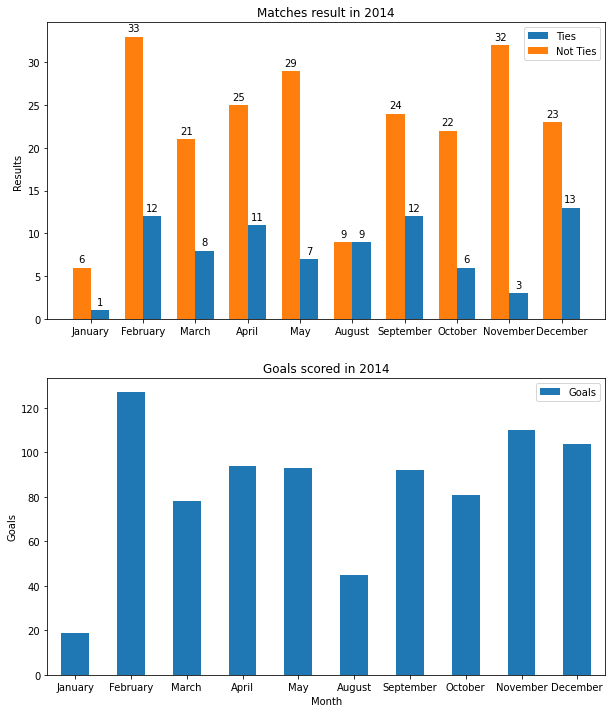

In [18]:
plotQuestionThreeResults(
    bundesliga_tie_result_2014.toPandas()['Month'], 
    2014, 
    bundesliga_tie_result_2014_ties['Ties'],
    bundesliga_tie_result_2014_ties['NotTie'],
    bundesliga_tie_result_2014.toPandas()
)

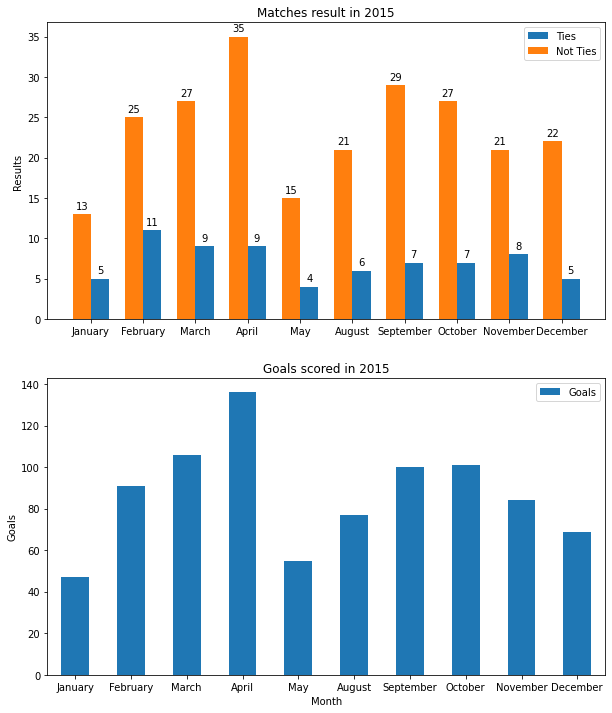

In [19]:
plotQuestionThreeResults(
    bundesliga_tie_result_2015.toPandas()['Month'], 
    2015, 
    bundesliga_tie_result_2015_ties['Ties'],
    bundesliga_tie_result_2015_ties['NotTie'],
    bundesliga_tie_result_2015.toPandas()
)

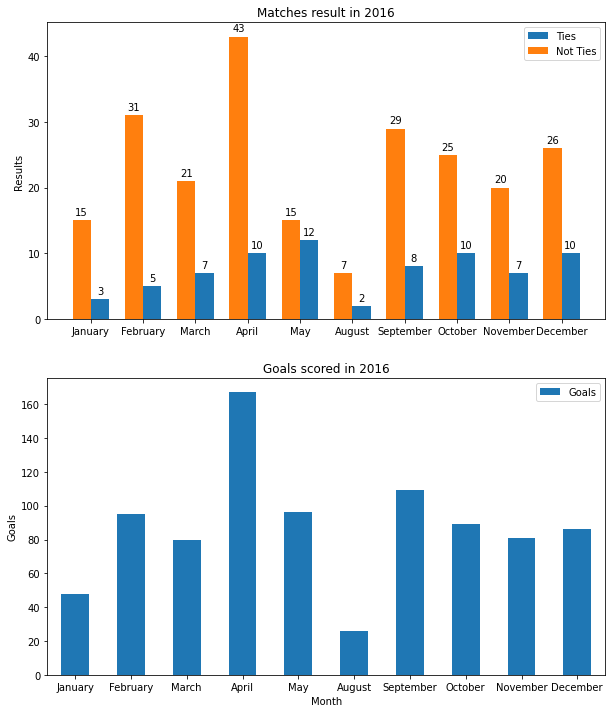

In [20]:
plotQuestionThreeResults(
    bundesliga_tie_result_2016.toPandas()['Month'], 
    2016, 
    bundesliga_tie_result_2016_ties['Ties'],
    bundesliga_tie_result_2016_ties['NotTie'],
    bundesliga_tie_result_2016.toPandas()
)

oktober fest doesnt seem to affect bundesliga performance, there is no abnormal behaviour in tied matches or goals scored

### 4) Which season of Bundesliga was the most competitive in the last decade?

In [27]:
# table.filter((col('TeamPosition') == 17) | (col('TeamPosition') == 18)).orderBy(desc('Season')).toPandas()
competitive_table_first = table.filter((col('TeamPosition') == 1))
competitive_table_second = table.filter((col('TeamPosition') == 2))
competitive_table_third = table.filter((col('TeamPosition') == 3))
competitive_table_fourth = table.filter((col('TeamPosition') == 4))
competitive_table_fourth.toPandas()

,Season,Team,GoalsScored,GoalsAgainst,GoalDifferentials,Wins,Losses,Tie,TotalPoints,TeamPosition
0,2007,Hamburg,47.0,26.0,73.0,14,8,12,54,4
1,2008,Hertha,48.0,41.0,89.0,19,9,6,63,4
2,2009,Leverkusen,65.0,38.0,103.0,15,5,14,59,4
3,2010,Hannover,49.0,45.0,94.0,19,12,3,60,4
4,2011,M'gladbach,49.0,24.0,73.0,17,8,9,60,4
5,2012,Schalke 04,58.0,50.0,108.0,16,11,7,55,4
6,2013,Leverkusen,60.0,41.0,101.0,19,11,4,61,4
7,2014,Leverkusen,62.0,37.0,99.0,17,7,10,61,4
8,2015,M'gladbach,67.0,50.0,117.0,17,13,4,55,4
9,2016,Hoffenheim,64.0,37.0,101.0,16,4,14,62,4


In [34]:
# could use victories and goals diff to rank later, will do if necessary
competitive_table = competitive_table_first.alias('first').join(competitive_table_second.alias('second'), "Season", how="inner") \
                        .join(competitive_table_third.alias('third'), 'Season', how='inner') \
                        .join(competitive_table_fourth.alias('fourth'), 'Season', how='inner') \
                        .withColumn('Winner', col('first.Team')) \
                        .withColumn('PointsDiffToSecond', col('first.TotalPoints') - col('second.TotalPoints')) \
                        .withColumn('PointsDiffToThird', col('first.TotalPoints') - col('third.TotalPoints')) \
                        .withColumn('PointsDiffToFourth', col('first.TotalPoints') - col('fourth.TotalPoints')) \
                        .drop('GoalsScored', 'GoalsAgainst', 'GoalDifferentials', 'Wins', 'Losses', 'Tie') \
                        .drop('Team', 'TeamPosition', 'TotalPoints')
                        

competitive_table.sort(['PointsDiffToSecond', 'PointsDiffToThird', 'PointsDiffToFourth']).toPandas()

,Season,Winner,PointsDiffToSecond,PointsDiffToThird,PointsDiffToFourth
0,2008,Wolfsburg,2,5,6
1,2009,Bayern Munich,5,9,11
2,2010,Dortmund,7,10,15
3,2011,Dortmund,8,17,21
4,2007,Bayern Munich,10,12,22
5,2014,Bayern Munich,10,13,18
6,2015,Bayern Munich,10,28,33
7,2016,Bayern Munich,15,18,20
8,2013,Bayern Munich,19,26,29
9,2012,Bayern Munich,25,26,36


the most competitive season was 2008 when Wolfsburg was champion by a 2 points difference from the second place